TODO: 

Specific Test V. Physics-Guided ML

Task: Build a model for classifying the images into lenses using PyTorch or Keras. Your architecture should take the form of a physics informed neural network (PINN). In this case, use the gravitational lensing equation in your architecture to improve network performance over your Common Test result. 

Dataset: dataset.zip - Google Drive

Dataset Description: The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.
Evaluation Metrics: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 


REFERENCES:



In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob


In [2]:

class NpyImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the .npy image files
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.transform = transform
        
        # Get all .npy files
        self.image_paths = []
        self.labels = []
        
        # Find all class directories
        class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

        print(class_dirs)
        self.class_to_idx = {class_name: i for i, class_name in enumerate(class_dirs)}
        
        # Collect all .npy files and their labels
        for class_name in class_dirs:
            class_path = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for file_path in glob.glob(os.path.join(class_path, '*.npy')):
                self.image_paths.append(file_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = np.load(self.image_paths[idx])
        label = self.labels[idx]
        
        # Convert to torch tensor
        image = torch.from_numpy(image).float()
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations (modify as needed)
transform = transforms.Compose([
    # Add any preprocessing steps here
    # Example: transforms.Resize((224, 224)),
    # Example: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    


        # def standardize(x, datatype, root):
        #     '''Standardize image examples'''
        #     # Make image contrast similar across all images
        #     x = ((x - np.mean(x, axis=(1, 2), keepdims=True)) /
        #         np.std(x, axis=(1, 2), keepdims=True))
        #     return x

        # ### Preprocess data ###

        # # Shuffle train data
        # perm = np.random.permutation(len(X_TRAIN))
        # X_TRAIN, Y_TRAIN = X_TRAIN[perm], Y_TRAIN[perm]

        # # Standardize data
        # X_TRAIN = standardize(X_TRAIN, 'train', OUTPATH)
        # X_VAL = standardize(X_VAL, 'val', OUTPATH)


])

# Create dataset
dataset_train = NpyImageDataset(data_dir='/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/dataset/dataset/train', transform=transform)
dataset_val = NpyImageDataset(data_dir='/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/dataset/dataset/val', transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)


# Quick check of the data
print(f"Dataset size: {len(dataset_train)}")
print(f"Number of classes: {len(dataset_train.class_to_idx)}")
print(f"Class mapping: {dataset_train.class_to_idx}")

# Print Val details
print(f"Dataset size: {len(dataset_val)}")
print(f"Number of classes: {len(dataset_val.class_to_idx)}")
print(f"Class mapping: {dataset_val.class_to_idx}")


['no', 'vort', 'sphere']
['no', 'vort', 'sphere']
Dataset size: 30000
Number of classes: 3
Class mapping: {'no': 0, 'vort': 1, 'sphere': 2}
Dataset size: 7500
Number of classes: 3
Class mapping: {'no': 0, 'vort': 1, 'sphere': 2}


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

/home/vimarsh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# import torchvision.models as models
# from torchvision import transforms

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Basic ResNet Block (similar to ResNet18)
# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out


# import torchvision.models as models

# input_channels = 1

# # Since our notebook already has a pre-trained ResNet18, let's modify it to match our input shape
# # Get the pre-trained ResNet18 model
# model_resnet = models.resnet18(pretrained=False)

# # Modify the first layer to accept single-channel input (grayscale images)
# # The default ResNet18 expects 3-channel input (RGB images)
# model_resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# # Modify the final fully connected layer to output the correct number of classes (3)
# model_resnet.fc = nn.Linear(512, 3)



In [5]:
# # Physics Layer to incorporate gravitational lensing equations
# class GravitationalLensingLayer(nn.Module):
#     def __init__(self, input_size):
#         super(GravitationalLensingLayer, self).__init__()
#         # Parameters for the lensing equation - these will be learned
#         self.einstein_radius = nn.Parameter(torch.tensor(1.0))
#         self.lens_strength = nn.Parameter(torch.tensor(0.5))
        
#         # Create a grid of coordinates
#         x = torch.linspace(-1, 1, input_size)
#         y = torch.linspace(-1, 1, input_size)
#         self.x_grid, self.y_grid = torch.meshgrid(x, y)
#         self.x_grid = self.x_grid.to(device)
#         self.y_grid = self.y_grid.to(device)
        
#     def forward(self, x):
#         batch_size = x.shape[0]
        
#         # Extract features that will inform our lensing parameters
#         # For each image, predict lensing parameters (can be adjusted based on class)
#         lens_strength = self.lens_strength.expand(batch_size)
#         einstein_radius = self.einstein_radius.expand(batch_size)
        
#         # This part represents how we would incorporate lensing physics
#         # In a real implementation, we would compute the deflection angles
#         # Here we're calculating a physics-based feature map that we concatenate with our CNN features
        
#         # Calculate radial distance from center for each point
#         r = torch.sqrt(self.x_grid**2 + self.y_grid**2)
#         r = r.unsqueeze(0).repeat(batch_size, 1, 1, 1)
        
#         # Simple model of deflection angle in gravitational lensing
#         # α(r) = θₑ²/r where θₑ is the Einstein radius
#         # This is a simplified version; full lensing would involve more complex calculations
#         einstein_radius = einstein_radius.view(batch_size, 1, 1, 1)
#         deflection = (einstein_radius**2) / (r + 1e-6)  # Add small epsilon to avoid division by zero
        
#         # Create a physics-informed feature map
#         physics_features = lens_strength.view(batch_size, 1, 1, 1) * deflection
        
#         # We can either return this for concatenation or apply it directly as a transformation
#         return physics_features

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Basic ResNet Block (similar to ResNet18)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Improved Physics Layer to incorporate gravitational lensing equations
class GravitationalLensingLayer(nn.Module):
    def __init__(self, input_size):
        super(GravitationalLensingLayer, self).__init__()
        # Initialize parameters for the lensing equation
        self.input_size = input_size
        
        # Learn different lensing parameters for each class
        self.einstein_radius = nn.Parameter(torch.tensor([0.1, 0.5, 0.7]))  # For no lens, vortex, subhalo
        self.ellipticity = nn.Parameter(torch.tensor([0.1, 0.5, 0.2]))  # For shape distortion
        self.orientation = nn.Parameter(torch.tensor([0.0, 3.14/2, 0.0]))  # Orientation angle
        
        # Create a grid of coordinates
        x = torch.linspace(-1, 1, input_size)
        y = torch.linspace(-1, 1, input_size)
        self.x_grid, self.y_grid = torch.meshgrid(x, y)
        self.x_grid = self.x_grid.to(device)
        self.y_grid = self.y_grid.to(device)
        
    def lensing_potential(self, r, class_idx):
        # Gravitational lensing potential: ψ(r) = θₑ² ln(r)
        # This is a simplification of the lensing potential
        einstein_radius = self.einstein_radius[class_idx]
        return einstein_radius**2 * torch.log(r + 1e-5)
    
    def deflection_angle(self, x, y, class_idx):
        # Calculate deflection angle from potential gradient
        # α = ∇ψ
        r = torch.sqrt(x**2 + y**2)
        einstein_radius = self.einstein_radius[class_idx]
        ellipticity = self.ellipticity[class_idx]
        orientation = self.orientation[class_idx]
        
        # Basic circular deflection (SIS model)
        alpha_r = einstein_radius**2 / (r + 1e-5)
        
        # Add ellipticity effects
        cos_theta = x / (r + 1e-5)
        sin_theta = y / (r + 1e-5)
        
        # Rotate by orientation angle
        cos_2phi = torch.cos(2 * (torch.atan2(y, x) - orientation))
        
        # Modified deflection with ellipticity
        alpha_x = alpha_r * (cos_theta - ellipticity * cos_2phi * sin_theta)
        alpha_y = alpha_r * (sin_theta + ellipticity * cos_2phi * cos_theta)
        
        return alpha_x, alpha_y
        
    def forward(self, x, pred_class=None):
        batch_size = x.shape[0]
        
        # Create feature maps for all classes
        feature_maps = []
        for class_idx in range(3):  # For each class: no lens, vortex, subhalo
            # Calculate deflection angles
            alpha_x, alpha_y = self.deflection_angle(self.x_grid, self.y_grid, class_idx)
            
            # Create a lensed image (simplified demonstration)
            # In real lensing, we would distort the original image based on deflection
            lensing_map = alpha_x**2 + alpha_y**2
            lensing_map = lensing_map.unsqueeze(0).repeat(batch_size, 1, 1)
            
            feature_maps.append(lensing_map.unsqueeze(1))
        
        # Stack feature maps for all classes
        all_class_features = torch.cat(feature_maps, dim=1)  # [batch_size, 3, H, W]
        
        # If we have predicted classes, select the appropriate feature map
        if pred_class is not None:
            # Select feature map based on predicted class
            # This is used during inference or when we have strong predictions
            batch_indices = torch.arange(batch_size, device=device)
            selected_features = all_class_features[batch_indices, pred_class].unsqueeze(1)
            return selected_features
        
        return all_class_features

# Improved PINN model combining ResNet features with physics
class LensingPINN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3, image_size=128):
        super(LensingPINN, self).__init__()
        self.in_planes = 64
        self.image_size = image_size
        self.num_classes = num_classes

        # ResNet-like backbone
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Physics-informed layer
        self.physics_layer = GravitationalLensingLayer(image_size)
        
        # Attention mechanism to combine physics with CNN features
        self.attention_conv = nn.Conv2d(3, 1, kernel_size=1)  # For attending to class-specific physics
        
        # Fusion layers (combining CNN and physics features)
        self.physics_proc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Fusion with gating mechanism
        self.fusion_gate = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Classification head
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Extract CNN features
        x_cnn = F.relu(self.bn1(self.conv1(x)))
        x_cnn = self.layer1(x_cnn)
        x_cnn = self.layer2(x_cnn)
        x_cnn = self.layer3(x_cnn)
        x_cnn = self.layer4(x_cnn)
        
        # Extract physics features for all classes
        x_phys_all = self.physics_layer(x)  # [batch_size, 3, H, W]
        
        # Process physics features
        x_phys_proc = self.physics_proc(x_phys_all)
        
        # Size adjustment if needed
        if x_phys_proc.shape[2:] != x_cnn.shape[2:]:
            x_phys_proc = F.interpolate(x_phys_proc, size=x_cnn.shape[2:], mode='bilinear', align_corners=False)
        
        # Gated fusion of CNN and physics features
        gate = self.fusion_gate(x_cnn)
        x_fused = x_cnn + gate * x_phys_proc
        
        # Classification
        x_pool = self.avg_pool(x_fused)
        x_flat = x_pool.view(x_pool.size(0), -1)
        out = self.fc(x_flat)
        
        return out
    
    def physics_consistency_loss(self, outputs, targets, images):
        """
        Compute physics-informed consistency loss based on gravitational lensing principles
        """
        batch_size = outputs.shape[0]
        
        # Calculate softmax probabilities
        probs = F.softmax(outputs, dim=1)
        
        # Create one-hot encoded targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()
        
        # Extract physics features for all classes
        phys_features = self.physics_layer(images)  # [batch_size, 3, H, W]
        
        # Compute consistency loss
        # For each sample, the physics of the true class should match the image better
        
        # 1. Mean physics feature for each class
        phys_mean = phys_features.mean(dim=(2, 3))  # [batch_size, 3]
        
        # 2. For correct class, physics features should be higher (more activation)
        class_consistency = -torch.sum(phys_mean * targets_one_hot, dim=1).mean()
        
        # 3. Physics of predicted class should match predicted probabilities
        pred_consistency = F.mse_loss(phys_mean, probs)
        
        # 4. Class-specific physics constraints
        # No lens class (0) should have minimal distortion
        no_lens_constraint = self.physics_layer.einstein_radius[0].abs()
        
        # Vortex class (1) should have high ellipticity
        vortex_constraint = F.relu(0.4 - self.physics_layer.ellipticity[1])
        
        # Subhalo class (2) should have medium einstein radius
        subhalo_constraint = F.relu(0.3 - self.physics_layer.einstein_radius[2])
        
        # Combine constraints
        parameter_consistency = no_lens_constraint + vortex_constraint + subhalo_constraint
        
        # Total physics loss
        physics_loss = class_consistency + 0.5 * pred_consistency + 0.1 * parameter_consistency
        
        return physics_loss

In [7]:
def train(model, train_loader, optimizer, epoch, device, physics_weight=0.1, warmup_epochs=3):
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_phys_loss = 0
    correct = 0
    total = 0
    
    # Learning rate warmup
    if epoch < warmup_epochs:
        # Gradually increase physics loss weight during warmup
        current_physics_weight = physics_weight * (epoch + 1) / warmup_epochs
    else:
        current_physics_weight = physics_weight
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Handle grayscale images
        if inputs.shape[1] != 1:
            inputs = inputs.mean(dim=1, keepdim=True)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Standard cross-entropy loss
        ce_loss = F.cross_entropy(outputs, targets)
        
        # Physics-informed loss
        phys_loss = model.physics_consistency_loss(outputs, targets, inputs)
        
        # Combined loss with gradual physics weight
        loss = ce_loss + current_physics_weight * phys_loss
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        total_phys_loss += phys_loss.item()
        
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch} | Batch: {batch_idx} | Loss: {loss.item():.4f} | '
                  f'CE Loss: {ce_loss.item():.4f} | Phys Loss: {phys_loss.item():.4f} | '
                  f'Phys Weight: {current_physics_weight:.4f} | Acc: {100.*correct/total:.2f}%')
    
    train_loss = total_loss / len(train_loader)
    train_ce_loss = total_ce_loss / len(train_loader)
    train_phys_loss = total_phys_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return train_loss, train_ce_loss, train_phys_loss, train_acc

def validate(model, val_loader, device, physics_weight=0.1):
    model.eval()
    total_loss = 0
    total_ce_loss = 0
    total_phys_loss = 0
    correct = 0
    total = 0
    
    all_targets = []
    all_scores = []
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Handle grayscale images
            if inputs.shape[1] != 1:
                inputs = inputs.mean(dim=1, keepdim=True)
            
            outputs = model(inputs)
            
            # Standard cross-entropy loss
            ce_loss = F.cross_entropy(outputs, targets)
            
            # Physics-informed loss
            phys_loss = model.physics_consistency_loss(outputs, targets, inputs)
            
            # Combined loss
            loss = ce_loss + physics_weight * phys_loss
            
            total_loss += loss.item()
            total_ce_loss += ce_loss.item()
            total_phys_loss += phys_loss.item()
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store targets and scores for ROC calculation
            all_targets.append(targets.cpu().numpy())
            all_scores.append(F.softmax(outputs, dim=1).cpu().numpy())
    
    val_loss = total_loss / len(val_loader)
    val_ce_loss = total_ce_loss / len(val_loader)
    val_phys_loss = total_phys_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets)
    all_scores = np.concatenate(all_scores)
    
    return val_loss, val_ce_loss, val_phys_loss, val_acc, all_targets, all_scores

def plot_roc_curve(targets, scores, class_names):
    """
    Plot ROC curve for multi-class classification
    """
    # One-hot encode targets
    n_classes = len(class_names)
    targets_one_hot = np.eye(n_classes)[targets]
    
    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(10, 8))
    
    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.plot(
            fpr[i], 
            tpr[i], 
            lw=2, 
            label=f'ROC curve of {class_name} (area = {roc_auc[i]:.2f})'
        )
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    
    # Calculate macro-average AUC
    macro_auc = sum(roc_auc.values()) / n_classes
    print(f"Macro-average AUC: {macro_auc:.4f}")
    
    plt.savefig('roc_curve.png')
    plt.show()
    
    return roc_auc, macro_auc

def plot_loss_curves(train_losses, val_losses):
    """
    Plot training and validation loss curves
    """
    plt.figure(figsize=(12, 5))
    
    # Plot total loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses['total'], label='Train Loss')
    plt.plot(val_losses['total'], label='Val Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CE loss
    plt.subplot(1, 3, 2)
    plt.plot(train_losses['ce'], label='Train CE Loss')
    plt.plot(val_losses['ce'], label='Val CE Loss')
    plt.title('Cross-Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot physics loss
    plt.subplot(1, 3, 3)
    plt.plot(train_losses['phys'], label='Train Phys Loss')
    plt.plot(val_losses['phys'], label='Val Phys Loss')
    plt.title('Physics Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('loss_curves.png')
    plt.show()

/home/vimarsh/.local/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 0 | Batch: 0 | Loss: 1.1989 | CE Loss: 1.2095 | Phys Loss: -0.3171 | Phys Weight: 0.0333 | Acc: 25.00%
Epoch: 0 | Batch: 50 | Loss: 1.0897 | CE Loss: 1.1017 | Phys Loss: -0.3602 | Phys Weight: 0.0333 | Acc: 33.27%
Epoch: 0 | Batch: 100 | Loss: 1.1005 | CE Loss: 1.1231 | Phys Loss: -0.6782 | Phys Weight: 0.0333 | Acc: 33.14%
Epoch: 0 | Batch: 150 | Loss: 1.0538 | CE Loss: 1.0781 | Phys Loss: -0.7308 | Phys Weight: 0.0333 | Acc: 33.65%
Epoch: 0 | Batch: 200 | Loss: 1.1026 | CE Loss: 1.1187 | Phys Loss: -0.4834 | Phys Weight: 0.0333 | Acc: 33.60%
Epoch: 0 | Batch: 250 | Loss: 1.0855 | CE Loss: 1.1051 | Phys Loss: -0.5892 | Phys Weight: 0.0333 | Acc: 33.52%
Epoch: 0 | Batch: 300 | Loss: 1.0634 | CE Loss: 1.0865 | Phys Loss: -0.6907 | Phys Weight: 0.0333 | Acc: 33.57%
Epoch: 0 | Batch: 350 | Loss: 1.1211 | CE Loss: 1.1421 | Phys Loss: -0.6309 | Phys Weight: 0.0333 | Acc: 33.40%
Epoch: 0 | Batch: 400 | Loss: 1.0753 | CE Loss: 1.0924 | Phys Loss: -0.5101 | Phys Weight: 0.0333 | Acc: 33

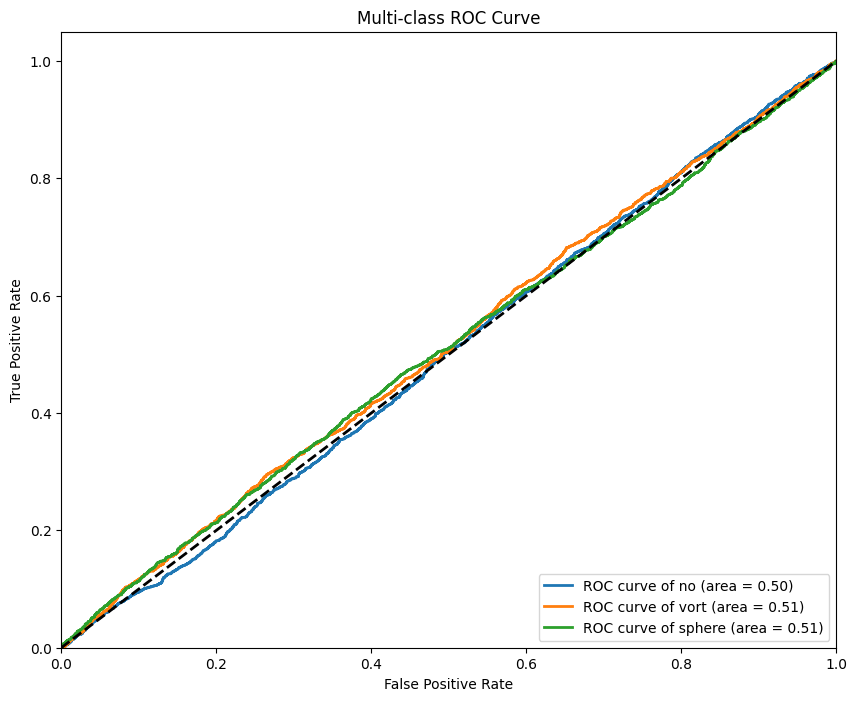

Epoch: 1 | Batch: 0 | Loss: 1.0921 | CE Loss: 1.1233 | Phys Loss: -0.4680 | Phys Weight: 0.0667 | Acc: 40.62%
Epoch: 1 | Batch: 50 | Loss: 1.0905 | CE Loss: 1.1253 | Phys Loss: -0.5215 | Phys Weight: 0.0667 | Acc: 32.60%
Epoch: 1 | Batch: 100 | Loss: 1.1387 | CE Loss: 1.1623 | Phys Loss: -0.3543 | Phys Weight: 0.0667 | Acc: 33.20%
Epoch: 1 | Batch: 150 | Loss: 1.0552 | CE Loss: 1.0681 | Phys Loss: -0.1935 | Phys Weight: 0.0667 | Acc: 33.38%
Epoch: 1 | Batch: 200 | Loss: 1.0457 | CE Loss: 1.0922 | Phys Loss: -0.6976 | Phys Weight: 0.0667 | Acc: 33.27%
Epoch: 1 | Batch: 250 | Loss: 1.0700 | CE Loss: 1.1059 | Phys Loss: -0.5388 | Phys Weight: 0.0667 | Acc: 33.06%
Epoch: 1 | Batch: 300 | Loss: 1.1166 | CE Loss: 1.1427 | Phys Loss: -0.3929 | Phys Weight: 0.0667 | Acc: 33.22%
Epoch: 1 | Batch: 350 | Loss: 1.0882 | CE Loss: 1.1252 | Phys Loss: -0.5559 | Phys Weight: 0.0667 | Acc: 33.24%
Epoch: 1 | Batch: 400 | Loss: 1.0453 | CE Loss: 1.0915 | Phys Loss: -0.6929 | Phys Weight: 0.0667 | Acc: 33

KeyboardInterrupt: 

In [8]:
num_epochs = 20
learning_rate = 0.001
physics_weight = 0.1  # Weight for physics-informed loss
image_size = 150  # Assuming 128x128 images
warmup_epochs = 3  # Gradual increase of physics loss

# Create model
model = LensingPINN(BasicBlock, [2, 2, 2, 2], num_classes=3, image_size=image_size).to(device)

# Define optimizer with weight decay for regularization
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Define scheduler - cosine annealing with restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=2, eta_min=1e-6
)

# Training and validation
best_val_acc = 0
class_names = ['no', 'vort', 'sphere']

# For tracking loss
train_losses = {'total': [], 'ce': [], 'phys': []}
val_losses = {'total': [], 'ce': [], 'phys': []}

for epoch in range(num_epochs):
    # Training
    train_loss, train_ce_loss, train_phys_loss, train_acc = train(
        model, train_loader, optimizer, epoch, device, physics_weight, warmup_epochs
    )
    
    # Validation
    val_loss, val_ce_loss, val_phys_loss, val_acc, targets, scores = validate(
        model, val_loader, device, physics_weight
    )
    
    # Update learning rate
    scheduler.step()
    
    # Store losses for plotting
    train_losses['total'].append(train_loss)
    train_losses['ce'].append(train_ce_loss)
    train_losses['phys'].append(train_phys_loss)
    
    val_losses['total'].append(val_loss)
    val_losses['ce'].append(val_ce_loss)
    val_losses['phys'].append(val_phys_loss)
    
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train CE: {train_ce_loss:.4f} | '
            f'Train Phys: {train_phys_loss:.4f} | Train Acc: {train_acc:.2f}% | '
            f'Val Loss: {val_loss:.4f} | Val CE: {val_ce_loss:.4f} | '
            f'Val Phys: {val_phys_loss:.4f} | Val Acc: {val_acc:.2f}%')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_lensing_pinn_model.pth')
        print(f"Saved best model with validation accuracy: {best_val_acc:.2f}%")
        
        # Plot ROC curve for best model
        roc_auc, macro_auc = plot_roc_curve(targets, scores, class_names)

# Plot loss curves
plot_loss_curves(train_losses, val_losses)

# Load best model for final evaluation
model.load_state_dict(torch.load('best_lensing_pinn_model.pth'))
val_loss, val_ce_loss, val_phys_loss, val_acc, targets, scores = validate(
    model, val_loader, device, physics_weight
)

print(f"Final evaluation - Accuracy: {val_acc:.2f}%")
roc_auc, macro_auc = plot_roc_curve(targets, scores, class_names)

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
    'val_loss': val_loss,
    'roc_auc': roc_auc,
    'macro_auc': macro_auc
}, 'final_lensing_pinn_model.pth')